In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

# Data Loading and Preparation

Load the CSV files

In [2]:
# Columns names for the csv files
columns = ['Image', 'Class ID', 'Species ID', 'Breed ID']

In [3]:
# CSV files are white space seprated with no coolumn headers
train_df = pd.read_csv("/kaggle/input/vgg-oxford-pet-iii-t-dataset/annotations/annotations/trainval.txt", delim_whitespace=True, header=None, names=columns)
test_df  = pd.read_csv("/kaggle/input/vgg-oxford-pet-iii-t-dataset/annotations/annotations/test.txt", delim_whitespace=True, header=None, names=columns)

In [4]:
# train_df.head(25)
# test_df.head(25)

Create utils functions to create categorical data and image file paths so we can use the ImageDataGenerator class later on.

In [5]:
import string

def map_species(x):
    if x==1:
        return 'Cat'
    elif x==2:
        return 'Dog'
    else:
        return 'Unknown'

def map_breed(x):  
    return string.capwords(x.replace("_", " ")).rsplit(" ", 1)[0]

def map_image_file(x):
    return  f"/kaggle/input/vgg-oxford-pet-iii-t-dataset/images/images/{x}.jpg"

def map_trimap_file(x):
    return  f"/kaggle/input/vgg-oxford-pet-iii-t-dataset/annotations/annotations/trimaps/{x}.png"

Create the additional columns in the data frame for both the training and test dataset.

In [6]:
train_df['Species Name'] = train_df['Species ID'].apply(lambda x: map_species(x) ) 
train_df['Breed Name']   = train_df['Image'].apply(lambda x: map_breed(x) ) 
train_df['Image Path']   = train_df['Image'].apply(lambda x: map_image_file(x) )
train_df['Trimap Path']  = train_df['Image'].apply(lambda x: map_trimap_file(x) )

In [7]:
test_df['Species Name'] = test_df['Species ID'].apply(lambda x: map_species(x) ) 
test_df['Breed Name']   = test_df['Image'].apply(lambda x: map_breed(x) ) 
test_df['Image Path']   = test_df['Image'].apply(lambda x: map_image_file(x) )
test_df['Trimap Path']  = test_df['Image'].apply(lambda x: map_trimap_file(x) )

In [8]:
# Reshuffle rows
train_df = train_df.sample(frac=1, random_state=42)

# Image Data Generators

In [9]:
BATCH_SIZE = 32

image_height = 256
image_width  = 256

img_size = (image_height, image_width)
num_classes = 3 # 3 pixels levels in teh trimap mask.
batch_size = BATCH_SIZE

In [10]:
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [11]:
# Data augmentation and pre-processing using tensorflow
gen_image = ImageDataGenerator(rescale= 1./255.,)
gen_mask   = ImageDataGenerator()
 
train_generator = gen_image.flow_from_dataframe(
    train_df, 
    directory   = '', 
    x_col       = 'Image Path',
    color_mode  = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode  = None,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    seed        = 42)

train_mask_generator = gen_mask.flow_from_dataframe(
    train_df, 
    directory   = '', 
    x_col       = 'Trimap Path',
    color_mode  = "grayscale",
    target_size = (image_height, image_width), # image height , image width
    class_mode  = None,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    seed        = 42)

Found 3680 validated image filenames.
Found 3680 validated image filenames.


In [12]:
test_generator = gen_image.flow_from_dataframe(
    test_df, 
    directory   = '', 
    x_col       = 'Image Path',
    color_mode  = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode  = None,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    seed        = 42)

test_mask_generator = gen_mask.flow_from_dataframe(
    test_df, 
    directory   = '', 
    x_col       = 'Trimap Path',
    color_mode  = "grayscale",
    target_size = (image_height, image_width), # image height , image width
    class_mode  = None,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    seed        = 42)

Found 3669 validated image filenames.
Found 3669 validated image filenames.


Create an image and mask generator as there is a one to one mapping between image and mask that msut be enforced.

In [13]:
def image_mask_generator(image_generator, mask_generator):
    for (img, mask) in zip(image_generator, mask_generator):  
        # the pixels values are 1,2,3 so subtract 1 to be 0,1,2
        mask -= 1
        yield (img, mask)

In [14]:
train_generator_with_mask = image_mask_generator(train_generator, train_mask_generator)
test_generator_with_mask  = image_mask_generator(test_generator, test_mask_generator)

In [15]:
import cv2

def plot_images_mask(images, masks):
    
    for i in range(24):
        # Plot the cat or dog image 
        fig, ax  = plt.subplots(1, 3, figsize = (10,5))
        ax[0].imshow(images[i])
        ax[0].set_title("Image")

        # Plot tri map
        ax[1].imshow(masks[i])    
        ax[1].set_title("Tri Map")

        # Plot cat or dog with mask
        # Rescale mask 0...1 by dividing with max value
        sample         = np.array(np.squeeze(masks[i]/masks[i].max()), dtype = np.uint8)
        contours, hier = cv2.findContours(sample, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        sample_over_gt = cv2.drawContours(images[i], contours, -1, [0, 255, 0], thickness=-1)
        ax[2].imshow(sample_over_gt)
        ax[2].set_title("Image with mask countour")

# Plot Images

/tmp/ipykernel_32/1739322727.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax  = plt.subplots(1, 3, figsize = (10,5))


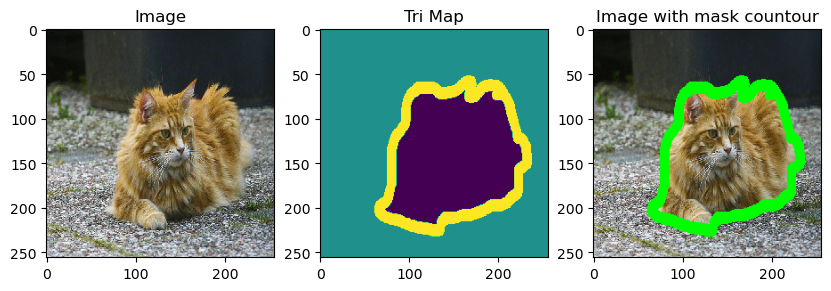

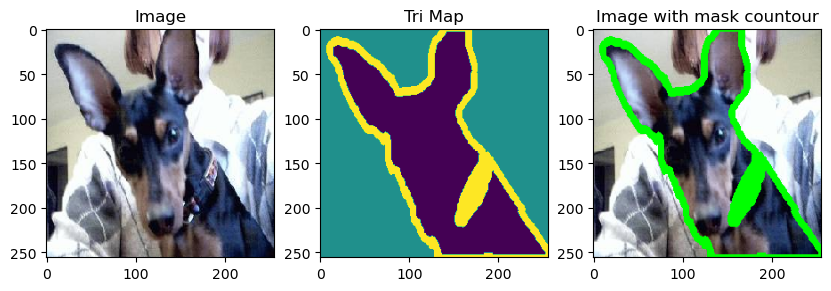

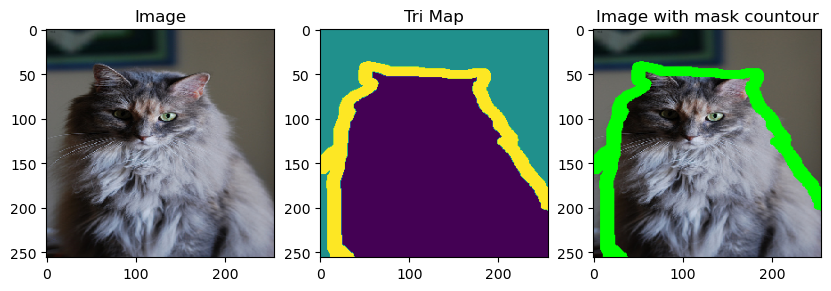

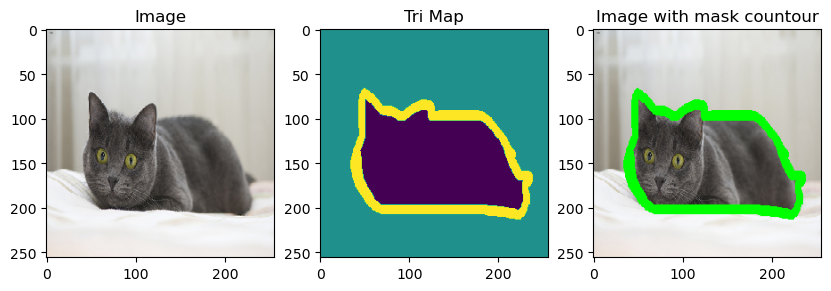

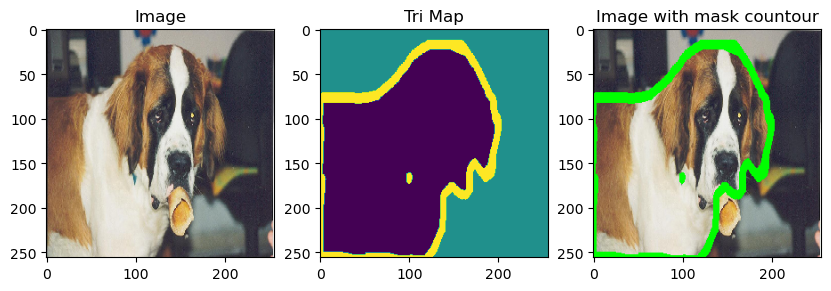

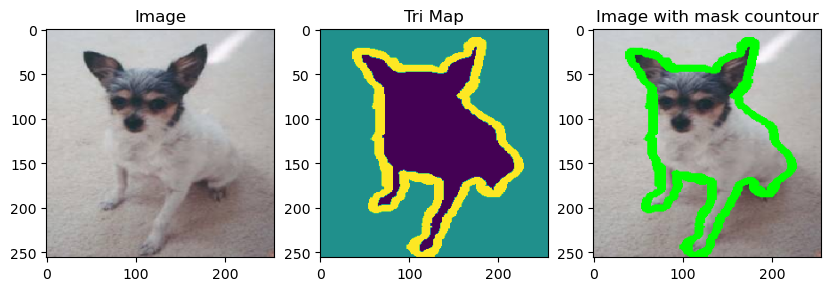

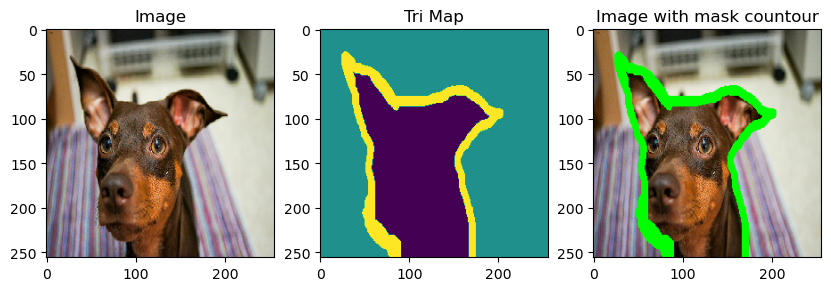

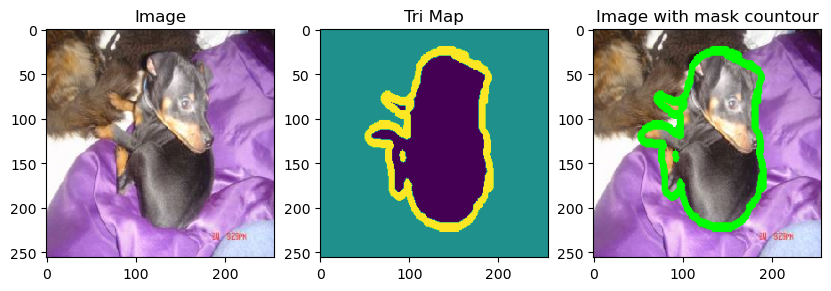

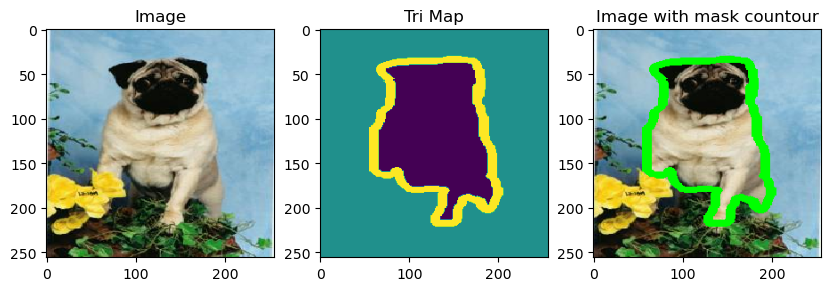

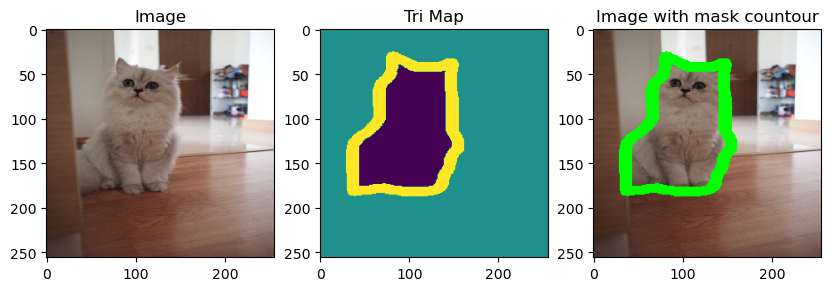

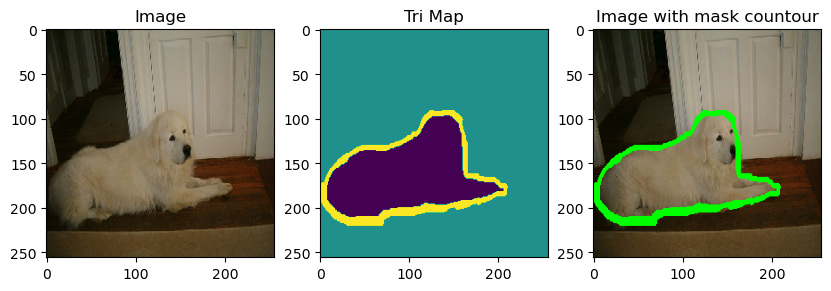

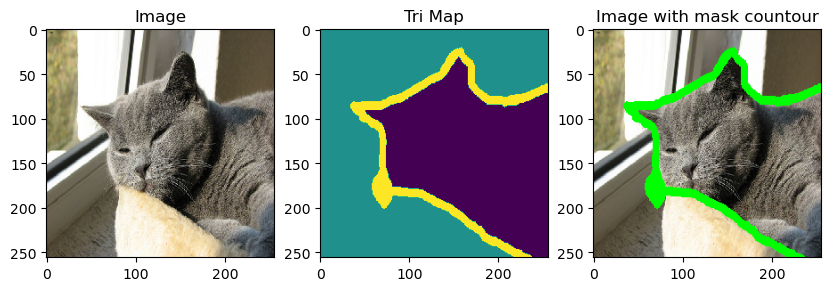

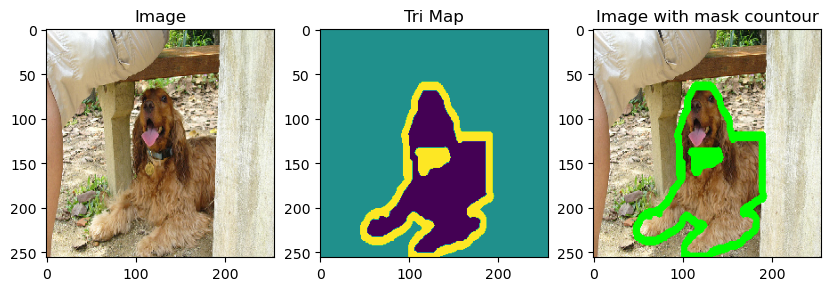

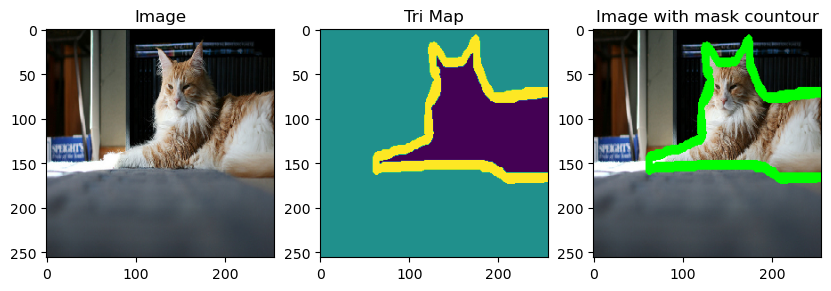

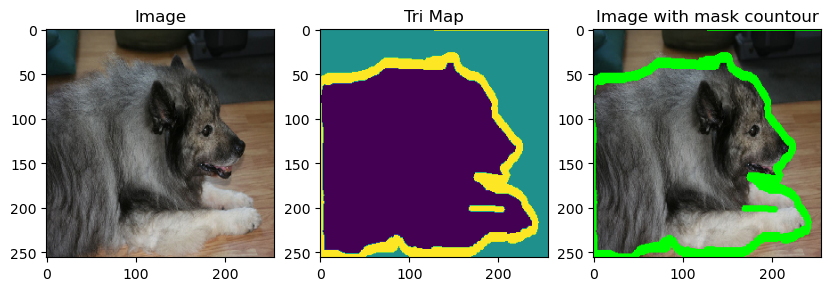

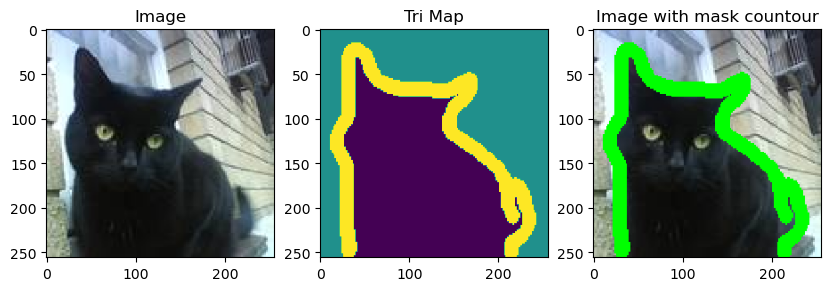

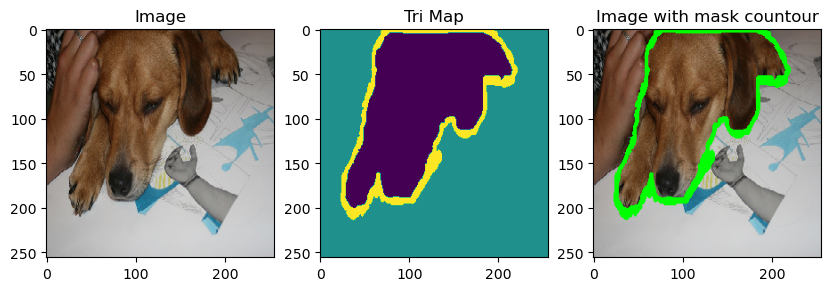

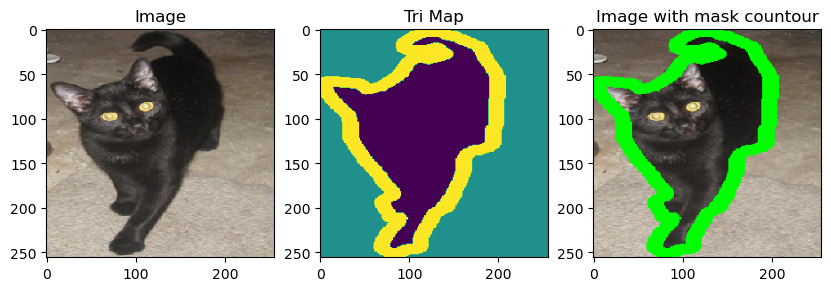

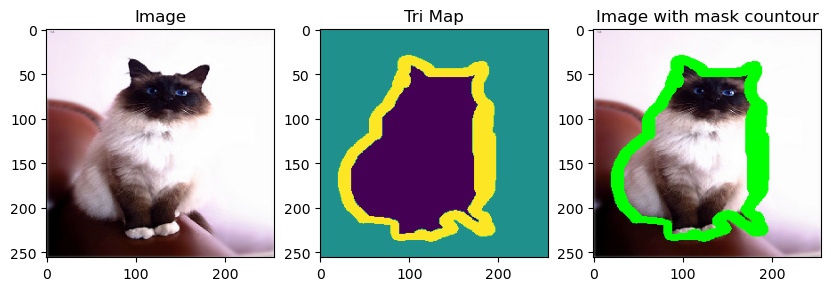

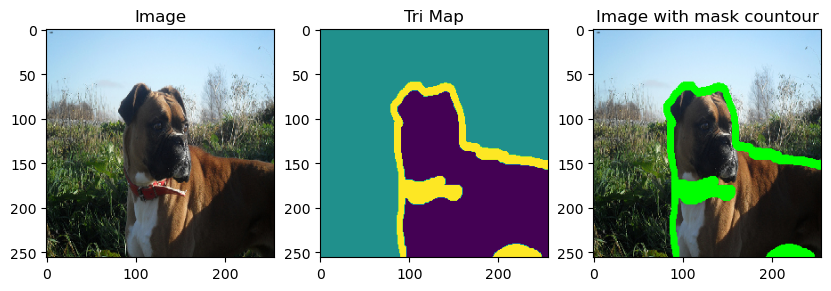

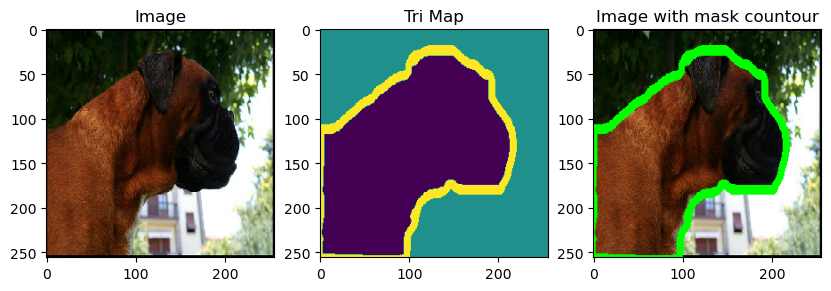

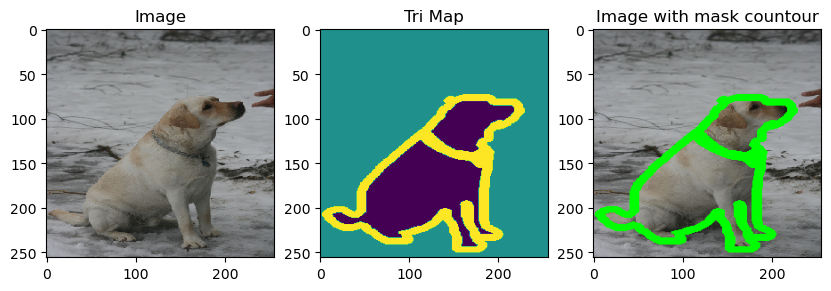

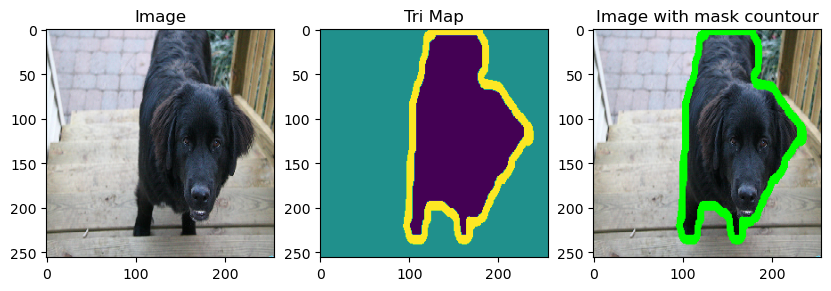

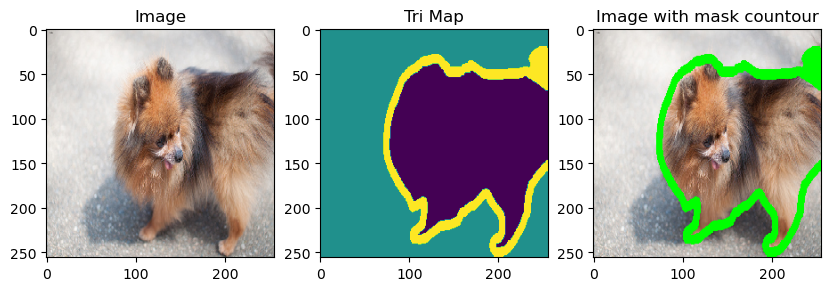

In [16]:
x,y = next(train_generator_with_mask)
plot_images_mask(x,y)

# Prepare U-Net Xception-style model
The network was copied from https://keras.io/examples/vision/oxford_pets_image_segmentation/

In [17]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
# model.summary()

In [18]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

early = tf.keras.callbacks.EarlyStopping( patience = 10,
                                          min_delta = 0.001,
                                          restore_best_weights = True)
    
callbacks = [early]

# Train the model, doing validation at the end of each epoch.
epochs = 30

# steps_per_epoch must be defined otherwise will go on forever!
model.fit(train_generator_with_mask, epochs=epochs, callbacks=callbacks, steps_per_epoch = len(train_df)//BATCH_SIZE)

Epoch 1/30
115/115 [==============================] - 68s 403ms/step - loss: 1.2644
Epoch 2/30
115/115 [==============================] - 39s 343ms/step - loss: 0.6226
Epoch 3/30
115/115 [==============================] - 40s 349ms/step - loss: 0.5150
Epoch 4/30
115/115 [==============================] - 40s 346ms/step - loss: 0.4579
Epoch 5/30
115/115 [==============================] - 40s 348ms/step - loss: 0.4183
Epoch 6/30
115/115 [==============================] - 40s 347ms/step - loss: 0.3868
Epoch 7/30
115/115 [==============================] - 40s 346ms/step - loss: 0.3642
Epoch 8/30
115/115 [==============================] - 40s 347ms/step - loss: 0.3400
Epoch 9/30
115/115 [==============================] - 40s 346ms/step - loss: 0.3206
Epoch 10/30
115/115 [==============================] - 40s 347ms/step - loss: 0.3003
Epoch 11/30
115/115 [==============================] - 40s 347ms/step - loss: 0.2847
Epoch 12/30
115/115 [==============================] - 40s 348ms/step - lo

# Display Predicted Masks

In [24]:
# get a batch for test predictions
x, y = next(test_generator_with_mask)

In [25]:
test_preds = model.predict(x)

1/1 [==============================] - 0s 33ms/step


In [26]:
def plot_images_pred_mask(images, true_masks,  pred_masks):
    
    for i in range(24):
        # Plot the cat or dog image 
        fig, ax  = plt.subplots(1,4,figsize = (10,5))
        ax[0].imshow(images[i])
        ax[0].set_title("Image")
        
        ax[1].imshow(true_masks[i])
        ax[1].set_title("True Trimap")

        # Plot tri map
        #ax[1].imshow(masks[i])    
        mask = np.argmax(pred_masks[i], axis=-1)
        mask = np.expand_dims(mask, axis=-1)
        ax[2].imshow(mask)  
        ax[2].set_title("Pred Tri Map")

        # Plot cat or dog with mask
        # Rescale mask 0...1
        sample = np.array(np.squeeze(mask/mask.max()), dtype = np.uint8)
        contours, hier = cv2.findContours(sample, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        sample_over_gt = cv2.drawContours(images[i], contours, -1, [0, 255, 0], thickness=-1)
        ax[3].imshow(sample_over_gt)
        ax[3].set_title("Image mask countour")

/tmp/ipykernel_32/945208902.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax  = plt.subplots(1,4,figsize = (10,5))


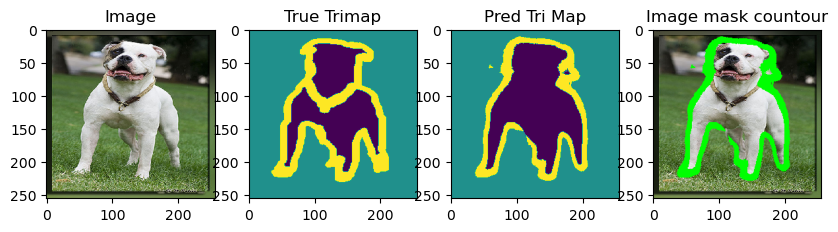

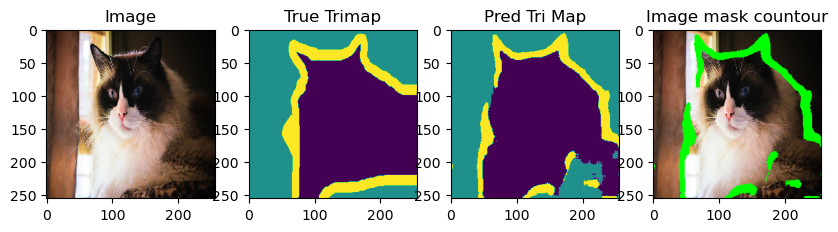

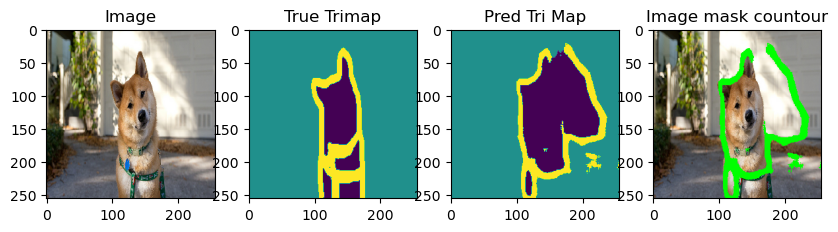

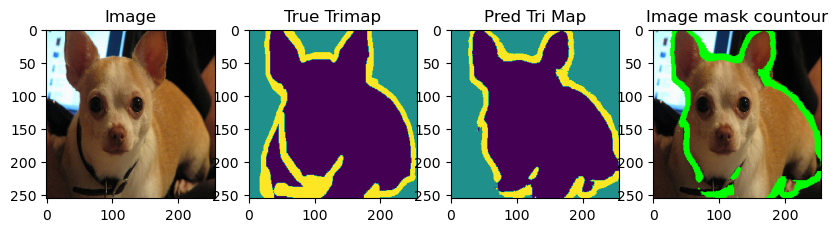

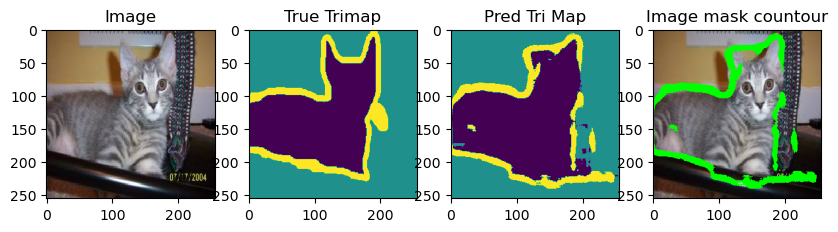

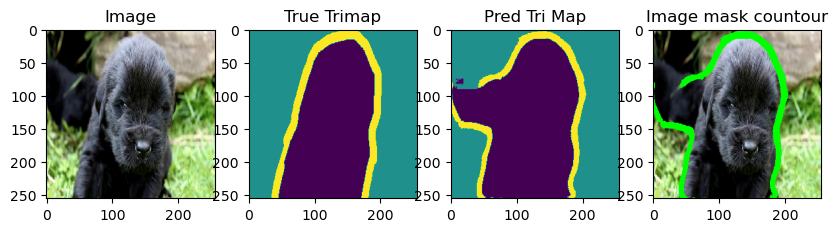

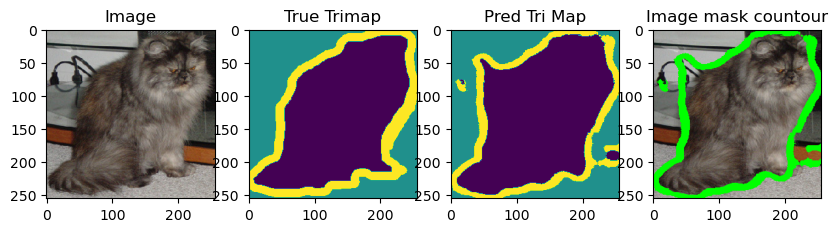

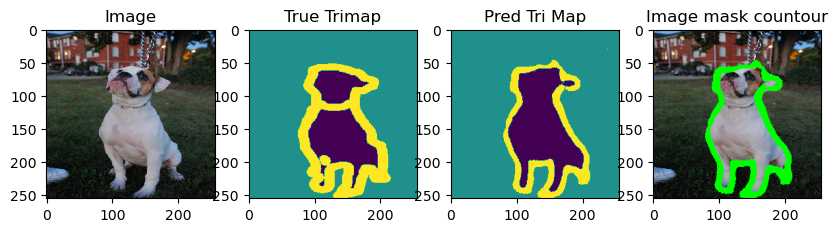

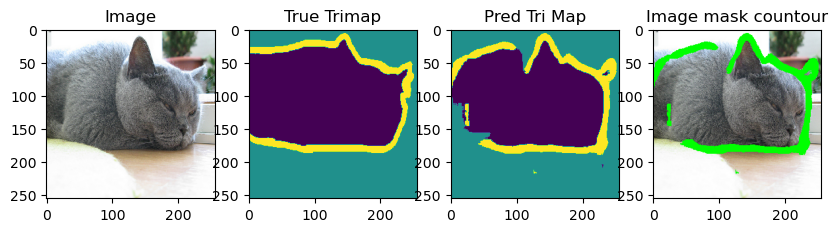

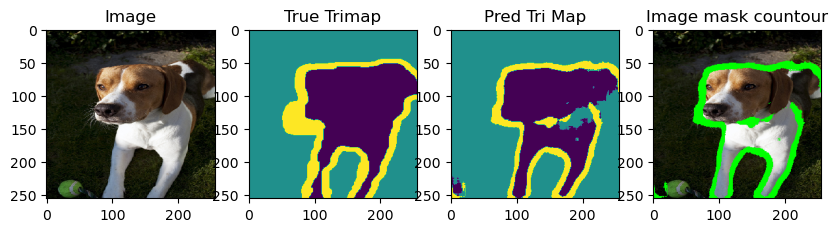

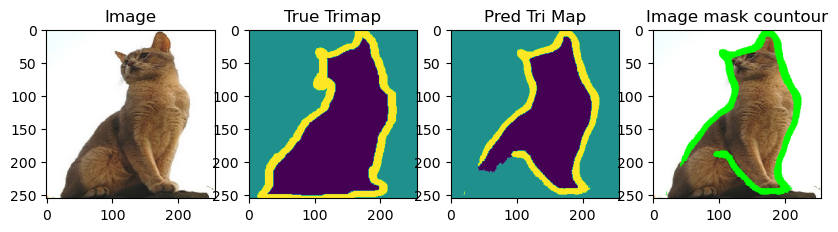

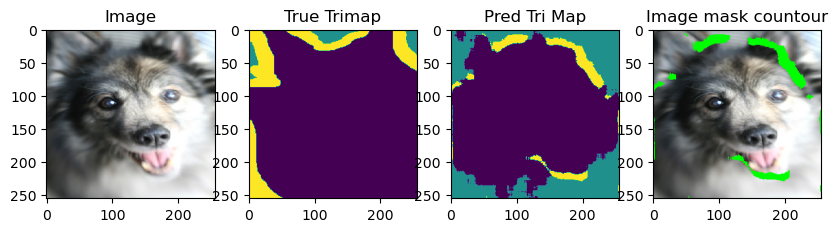

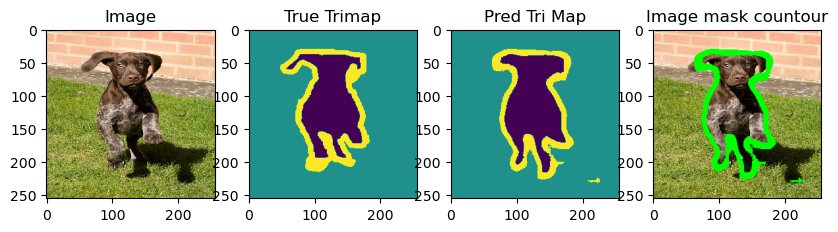

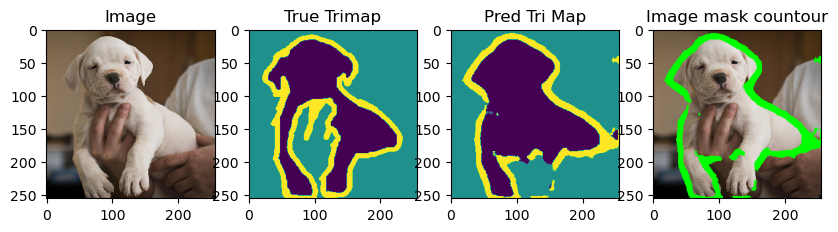

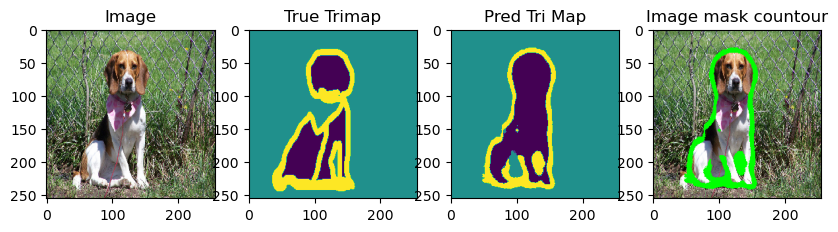

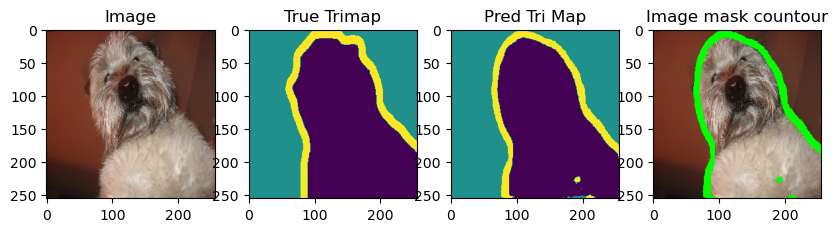

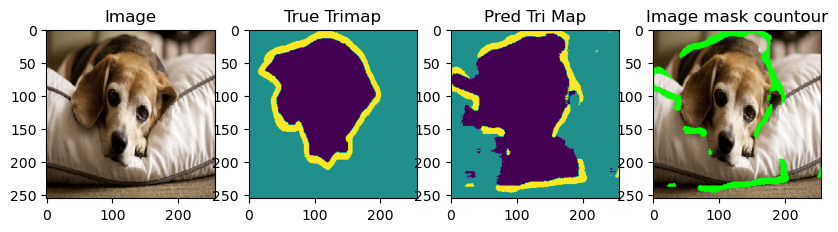

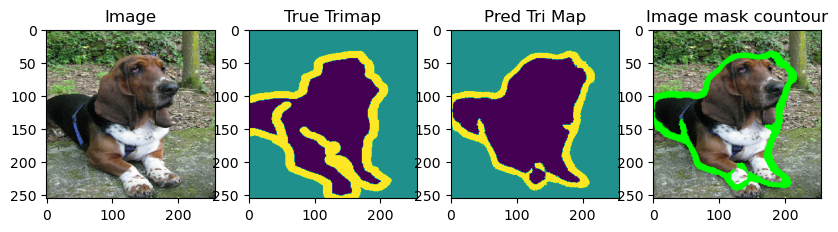

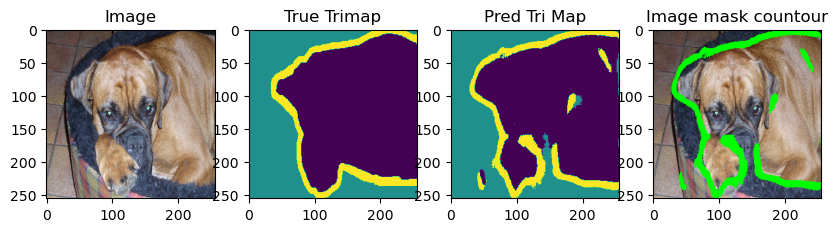

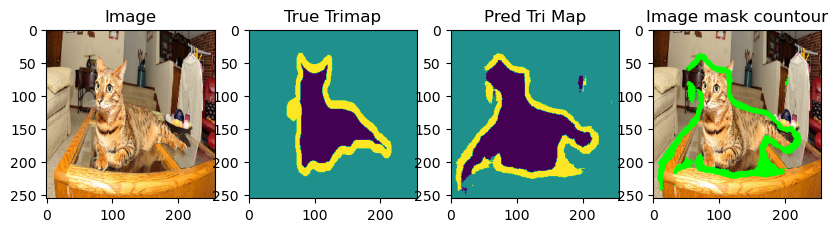

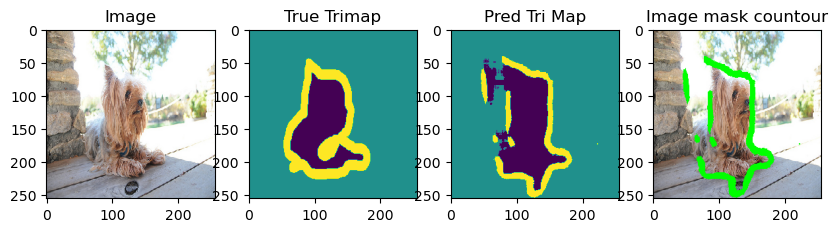

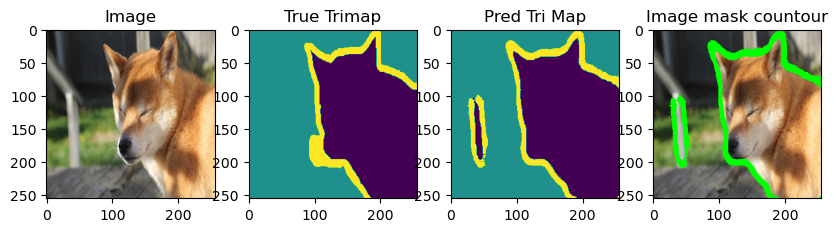

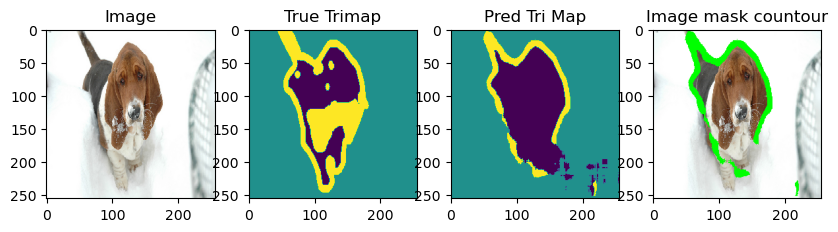

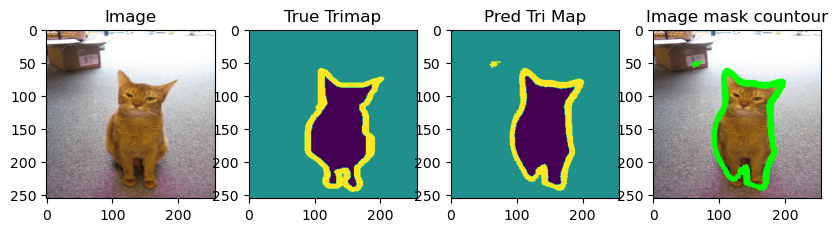

In [22]:
plot_images_pred_mask(x, y, test_preds)

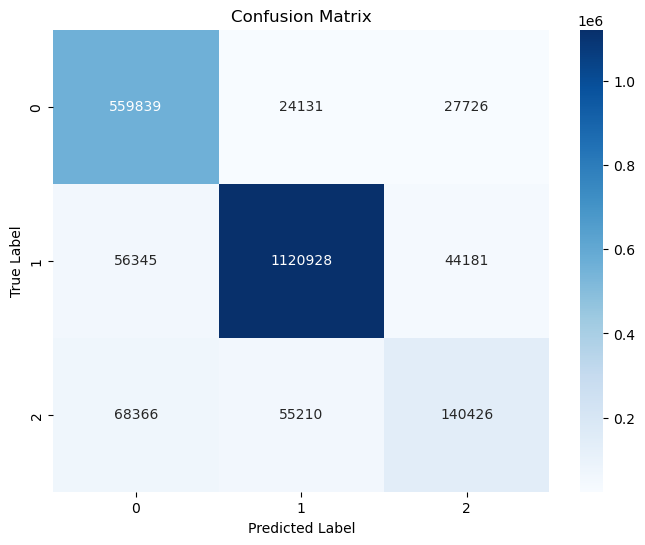

In [27]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns

# Define a function to compute and plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Prepare the true labels and predicted labels for confusion matrix
y_true = y.flatten()  # Flatten the true labels
y_pred = np.argmax(test_preds, axis=-1).flatten()  # Get predicted labels and flatten them

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred)

plt.show()